# Betting analysis notebook

- In this notebook I analyse the horse-racing data in 'horses.csv'. This is done using the pandas library.
- Functions have been vectorized in order to perform analysis on each horse and each race.
- Finally, I assess the results of the project and perform a Monte Carlo experiment to analyse the project given alternative outcomes.

In [1]:
%%html
<style>
table {float:left} <!-- Align results table to the left -->
</style>

## Results

|Result|Value|
| --- | --- |
|Turnover|£3,422,065|
|EV|£132,713|
|PnL|£147,777.01|
|Commission (@ 5%)|£72,974.63|
|Net PnL|£74,802.38|
|RoI|2.19%|

Here we can see that the turnover is very large relative to the PnL and the Net PnL. The result is a 2% RoI. This is a very small RoI considering the vast number of trades made. (A UK 2 year Gilt currently offers a 2% coupon rate).

The commission is the same order of magnitude as the Net PnL, this would suggest that there were a large number of races that lost money. This turns out to be the case since 4894 races resulted in a negative race PnL, this is approximately half of all races.

The largest win from a single race was: £ 3040.75. While the largest loss from a single race was: £ -1770.64.

## Betting analysis

This section is in two significant parts. First, the results in the table above are computed. Second, a Monte Carlo simulation is performed and the resulting RoI's are put into a histogram to find an appropriate confidence in the project.

The process is broken into multiple functions that operate on the original dataset (the pandas dataframe 'input_data') and the outputs may be added to: the dataframe 'horses'; the dataframe 'race_analysis'; or the dataframe 'project_analysis'.

### The structure of each dataframe:

#### input_data
Contains the original data from the horses.csv file.

#### horses
In addition to the original data from the horses.csv file, __for each horse__, this dataframe contains:

|Column|Description|
| --- | --- |
|side_final|The side that is taken: 'back'; 'lay'; 'neutral'|
|stake_final|Size of the backers stake|
|bet_ev|The EV given the side and stake|
|bet_pnl_final|PnL of each bet using 'winner' as in input (excl. commission)|


#### race_analysis
10,000 rows corresponding to one row per race.

|Column|Description|
| --- | --- |
|race_number|One row for each race|
|race_pnl|Sum of PnL of bets made on each horse within a race|
|race_commission|5% of any positive race_pnl otherwise £0.00|
|net_race_pnl|race_pnl - race_commission|

#### project_analysis
Contains one row. Each column corresponds to one of the results required in the document '2 Betting analysis.md'. This dataframe aggregates data from both 'horses' and 'race_analysis' dataframes to find totals for the whole project.

|Column|Description|
| --- | --- |
|total_turnover|Turnover for whole project|
|total_ev|EV for whole project|
|total_pnl|Total project PnL (excluding commission)|
|total_commission|Total projectcommission|
|net_total_pnl|Total project PnL (including commission)|
|roi|RoI, which is net PnL / turnover * 100%|

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

## Data

Read the 'horses.csv' file into a pandas dataframe.

In [3]:
# Read the CSV data into a pandas dataframe
input_data = pd.read_csv("horses.csv")
horses = input_data.copy()
# Display the head of the dataframe
horses.head()

,race_number,saddle_number,win_fair_price,win_starting_price,winner
0,1,4,1.7353,1.7098,1
1,1,1,6.0313,6.0914,0
2,1,5,7.6923,7.5101,0
3,1,6,20.3325,20.4978,0
4,1,2,23.9991,23.4710,0


In [4]:
# What data types are used?
horses.dtypes

race_number             int64
saddle_number           int64
win_fair_price        float64
win_starting_price    float64
winner                  int64
dtype: object

## Analysis

In [5]:
# Calculate the probability of a horse winning given it fair price
@np.vectorize
def find_probability_of_win(fair_price_decimal_odds):
    probability_of_win = 1.0 / fair_price_decimal_odds
    return probability_of_win

# Define the function to calculate the fraction of the bank to bet given the probability of success, the bank and the decimal odds given
@np.vectorize
def full_kelly(probability_of_win, bank, starting_decimal_odds): # Calculate full Kelly
    f_bank = ((starting_decimal_odds - 1.0) * probability_of_win - (1.0 - probability_of_win)) / (starting_decimal_odds - 1.0)
    return f_bank


# Calculate the stake -- and side?
@np.vectorize
def find_stake(fair_price_decimal_odds, bank, starting_decimal_odds):
    probability_of_win = find_probability_of_win(fair_price_decimal_odds)
    f_bank = full_kelly(probability_of_win, bank, starting_decimal_odds)
    full_kelly_stake = bank * abs(f_bank)
    
    #Find the side and stake when minimum bet is £2
    if f_bank > 0.0 and full_kelly_stake > 2.0:
        side = 'back'
        final_stake = full_kelly_stake
    elif f_bank < 0.0 and full_kelly_stake > 2.0:
        side = 'lay'
        final_stake = full_kelly_stake
    else:
        side = 'neutral'
        final_stake = 0.0

    return side, final_stake

# Calculate the profit or loss of a bet given the result
@np.vectorize
def find_bet_pnl(stake, starting_decimal_odds, winner, side):
    if side == 'back':
        side_factor = 1.0
    elif side == 'lay':
        side_factor = -1.0
    else:
        side_factor = 0.0
        
    if winner == 1:
        pnl = (starting_decimal_odds - 1.0) * stake * side_factor
    else:
        pnl = -1.0 * stake * side_factor
    
    return pnl

@np.vectorize
def find_ev(stake, win_fair_price, side, starting_decimal_odds):
    probability_of_win = find_probability_of_win(win_fair_price)
    if side == 'back':
        side_factor = 1.0
    elif side == 'lay':
        side_factor = -1.0
    else:
        side_factor = 0.0
        
    ev = (stake * (starting_decimal_odds - 1.0) * probability_of_win - (1.0 - probability_of_win) * stake) * side_factor
    
    return ev

### Calculate side and stake for a single horse

In [6]:
horses_side, horses_stake = find_stake(horses['win_fair_price'],
                                       10000,
                                       horses['win_starting_price'])


In [7]:
print('Length of the original data set: ', len(horses['race_number']))
print('Length of the calculated data set: ', len(horses_stake))

Length of the original data set:  86648
Length of the calculated data set:  86648


In [8]:
horses = horses.assign(side_final = horses_side, stake_final = horses_stake)
horses.head()

,race_number,saddle_number,win_fair_price,win_starting_price,winner,side_final,stake_final
0,1,4,1.7353,1.7098,1,lay,207.028254
1,1,1,6.0313,6.0914,0,back,19.571600
2,1,5,7.6923,7.5101,0,lay,36.383502
3,1,6,20.3325,20.4978,0,back,4.169620
4,1,2,23.9991,23.4710,0,lay,9.792618


### Calculate the EV for each horse

In [9]:
bet_ev = find_ev(horses['stake_final'], horses['win_fair_price'], horses['side_final'], horses['win_starting_price'])
horses = horses.assign(bet_ev = bet_ev)
horses.head()

,race_number,saddle_number,win_fair_price,win_starting_price,winner,side_final,stake_final,bet_ev
0,1,4,1.7353,1.7098,1,lay,207.028254,3.042252
1,1,1,6.0313,6.0914,0,back,19.571600,0.195025
2,1,5,7.6923,7.5101,0,lay,36.383502,0.861780
3,1,6,20.3325,20.4978,0,back,4.169620,0.033898
4,1,2,23.9991,23.4710,0,lay,9.792618,0.215486


### Calculate PnL for each bet on each horse given the result

In [10]:
bet_pnl = find_bet_pnl(horses['stake_final'],
                       horses['win_starting_price'],
                       horses['winner'],
                       horses['side_final'])

horses = horses.assign(bet_pnl_final = bet_pnl)
horses.head()

,race_number,saddle_number,win_fair_price,win_starting_price,winner,side_final,stake_final,bet_ev,bet_pnl_final
0,1,4,1.7353,1.7098,1,lay,207.028254,3.042252,-146.948654
1,1,1,6.0313,6.0914,0,back,19.571600,0.195025,-19.571600
2,1,5,7.6923,7.5101,0,lay,36.383502,0.861780,36.383502
3,1,6,20.3325,20.4978,0,back,4.169620,0.033898,-4.169620
4,1,2,23.9991,23.4710,0,lay,9.792618,0.215486,9.792618


###  Calculate PnL for each race

In [11]:
race_analysis = horses.groupby(['race_number']).agg({'bet_pnl_final': [sum]})
race_analysis.columns = ['race_pnl']
race_analysis.head()

,race_pnl
race_number,
1,-121.707054
2,12.091172
3,-33.633558
4,-59.230543
5,-136.782688


### Calculate commision and net PnL on each race

In [12]:
# Commission
@np.vectorize
def find_race_commission(race_pnl):
    if race_pnl > 0.0:
        race_commission = 0.05 * race_pnl
    else:
        race_commission = 0.0
        
    return race_commission

# Net PnL
@np.vectorize
def find_net_race_pnl(race_pnl, race_commission):
    return race_pnl - race_commission

In [13]:
race_commission = find_race_commission(race_analysis['race_pnl'])
net_race_pnl = find_net_race_pnl(race_analysis['race_pnl'], race_commission)

race_analysis = race_analysis.assign(race_commission = race_commission,
                                     net_race_pnl = net_race_pnl)
race_analysis.head()

,race_pnl,net_race_pnl,race_commission
race_number,,,
1,-121.707054,-121.707054,0.000000
2,12.091172,11.486614,0.604559
3,-33.633558,-33.633558,0.000000
4,-59.230543,-59.230543,0.000000
5,-136.782688,-136.782688,0.000000


### Calculate final results

* Turnover.
* EV.
* PnL.
* Commission, which is 5% of your race PnL in each race that your race PnL is positive.
* Net PnL, which is PnL - commission.
* RoI, which is net PnL / turnover * 100%.


In [14]:
# Calculate PnL, commission, and net PnL by aggregating the race level values
project_analysis = race_analysis.agg({'race_pnl': [sum], 'race_commission': [sum], 'net_race_pnl': [sum]})
project_analysis.rename(columns = {'race_pnl': 'total_pnl', 'race_commission': 'total_commission', 'net_race_pnl': 'net_total_pnl'}, inplace = True) 

# Calculate values using data from each individual bet
total_turnover = horses['stake_final'].sum()
total_ev = horses['bet_ev'].sum()
roi = project_analysis['net_total_pnl'] / total_turnover * 100

# Final table
project_analysis = project_analysis.assign(total_turnover = total_turnover, total_ev = total_ev, roi = roi)
project_analysis.head()

,net_total_pnl,total_commission,total_pnl,roi,total_ev,total_turnover
sum,74802.375776,72974.634522,147777.010298,2.185884,132712.789829,3.422065e+06


#### Analysis of the project:

In [15]:
# Count the number of races where the race PnL was negative
race_analysis[race_analysis.net_race_pnl < 0].count()

race_pnl           4894
net_race_pnl       4894
race_commission    4894
dtype: int64

In [16]:
# Calculate the largest loss
min_race_win = race_analysis['net_race_pnl'].min()

# Calculate the largest win
max_race_win = race_analysis['net_race_pnl'].max()

print('The largest win from a single race was: £', round(max_race_win,2))
print('The largest loss from a single race was: £', round(min_race_win,2))

The largest win from a single race was: £ 3040.75
The largest loss from a single race was: £ -1770.64


### Monte Carlo experiment

__It is very slow to run over 10000 simulations.__ To test the code, reduce the value in the parameter 'max_simulations'.

In [17]:
# Convert win_fair_price to probability of win
probability = find_probability_of_win(horses['win_fair_price'])
horses = horses.assign(probability = probability)

# Calculate the cumulative probability of win for each horse within the race
cumulative_prob = horses.groupby(['race_number'])['probability'].cumsum()
horses = horses.assign(cumulative_prob = cumulative_prob)
horses[:15]

,race_number,saddle_number,win_fair_price,win_starting_price,winner,side_final,stake_final,bet_ev,bet_pnl_final,probability,cumulative_prob
0,1,4,1.7353,1.7098,1,lay,207.028254,3.042252,-146.948654,0.576269,0.576269
1,1,1,6.0313,6.0914,0,back,19.571600,0.195025,-19.571600,0.165802,0.742071
2,1,5,7.6923,7.5101,0,lay,36.383502,0.861780,36.383502,0.130000,0.872071
3,1,6,20.3325,20.4978,0,back,4.169620,0.033898,-4.169620,0.049182,0.921253
4,1,2,23.9991,23.4710,0,lay,9.792618,0.215486,9.792618,0.041668,0.962922
5,1,3,26.9763,26.7811,0,lay,2.806700,0.020309,2.806700,0.037070,0.999991
6,2,7,5.6740,5.3143,0,lay,146.940247,9.315193,146.940247,0.176243,0.176243
7,2,3,5.7191,5.7597,0,back,14.914846,0.105881,-14.914846,0.174853,0.351095
8,2,1,6.0408,5.8167,0,lay,77.018987,2.857230,77.018987,0.165541,0.516636
9,2,5,6.7459,6.6124,0,lay,35.260848,0.697805,35.260848,0.148238,0.664874


In [18]:
# Generate random number to simulate the race
def run_race(a):
    winner = random.random()
    return winner


# Determine the winner
@np.vectorize
def race_winner(race_result, p_win, c_prob):
    # Find range random number must fall in for a given horse to win
    min_win = c_prob - p_win 
    max_win = c_prob
    
    if min_win <= race_result and race_result < max_win:
        return 1
    else:
        return 0

In [19]:
simulation = 0
project_analysis_mc_roi = pd.Series([])
max_simulations = 10000
while simulation < max_simulations:
    # Simulate a race
    race_rand_num = horses.groupby('race_number').apply(run_race)
    race_rand_num = race_rand_num.to_frame()
    race_rand_num = race_rand_num.rename(columns={0:'race_rand_num'})
    horses = horses.merge(race_rand_num, left_on='race_number', right_index=True)
    race_sim = race_winner(horses['race_rand_num'], horses['probability'], horses['cumulative_prob'])
    horses = horses.assign(winner_mc = race_sim)
    
    # Calculate PnL for each horse
    bet_pnl_mc = find_bet_pnl(horses['stake_final'],
                           horses['win_starting_price'],
                           horses['winner_mc'],
                           horses['side_final'])

    horses = horses.assign(bet_pnl_final_mc = bet_pnl_mc)

    # Calculate PnL for each race
    race_analysis_mc = horses.groupby(['race_number']).agg({'bet_pnl_final_mc': [sum]})
    race_analysis_mc.columns = ['race_pnl_mc']

    # Calculate commission and net PnL for each race
    race_commission_mc = find_race_commission(race_analysis_mc['race_pnl_mc'])
    net_race_pnl_mc = find_net_race_pnl(race_analysis_mc['race_pnl_mc'], race_commission_mc)

    race_analysis_mc = race_analysis_mc.assign(race_commission_mc = race_commission_mc,
                                         net_race_pnl_mc = net_race_pnl_mc)

    project_analysis_mc = race_analysis_mc.agg({'race_pnl_mc': [sum], 'race_commission_mc': [sum], 'net_race_pnl_mc': [sum]})
    project_analysis_mc.rename(columns = {'race_pnl_mc': 'total_pnl', 'race_commission_mc': 'total_commission_mc', 'net_race_pnl_mc': 'net_total_pnl_mc'}, inplace = True) 

    roi_mc = project_analysis_mc['net_total_pnl_mc'] / total_turnover * 100

    project_analysis_mc_roi = project_analysis_mc_roi.append(roi_mc)

    if (round((simulation / max_simulations) % 0.05,7) == 0):
        print('Progress: ', round(simulation / max_simulations * 100, 0), '%')

    
    horses = horses.drop(['race_rand_num'], axis = 1)
    simulation += 1
    
np.savetxt('Monte_Carlo_simulation_RoI_10000.csv', project_analysis_mc_roi.values, delimiter=',')

Progress:  0.0 %
Progress:  5.0 %
Progress:  10.0 %
Progress:  20.0 %
Progress:  40.0 %
Progress:  55.0 %
Progress:  80.0 %


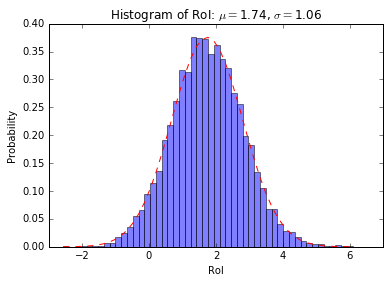

In [20]:
num_bins = 50
# The histogram of the data
n, bins, patches = plt.hist(project_analysis_mc_roi, num_bins, normed=1, facecolor='blue', alpha=0.5)

(mu, sigma) = norm.fit(project_analysis_mc_roi)

# Add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('RoI')
plt.ylabel('Probability')
plt.title(r'Histogram of RoI: $\mu=$' + str('%.2f' % round(mu,2)) +', $\sigma=$' + str('%.2f' % round(sigma,2)))

After running the simulation 10000 times we obtain a histogram where each calculation of RoI has been binned. As we can see, the data nicely fits a normal distribution with a mean of the normal distribution, $\mu = 1.74$, and the standard deviation of the distribution, $\sigma = 1.05$. 

We can see that the gambler has an edge since $\mu$ is positive. However, the probability of this project returning a negative RoI is .

This is by no means a risk free project. Especially after such a large number of races (10 000), the gamblers edge is not large enough to reduce the risk of a negative return to less than two standard deviations.

Further analysis would entail investigating the maximum drawdown and the maximum run of losses. By materialising the PnL of each race it would be possible to investigate the various paths taken to reach each final PnL. It would also be interesting to see how variations of the project would perform in comparison. For example, using a fixed bank at the beginning of the simulation and updating it with each race PnL.

I would also optimise the Monte Carlo code to make it more efficient. This would potentially entail: using more numpy arrays as opposed to pandas dataframes; enabling the code to run on multiple threads; and trimming the code where fewer lines could be used.